This notebook focuses on using GPR (acq. func is EI) to perform BO to determine maximum heat transfer coefficient.
1. X -> Viscosity, density, thermal conductivity, heat capacity (thermophysical properties); y -> heat transfer coeff
2. Random sampling was done on indices of dataset and then did initial_X, initial_y = X[indices], y[indices]
3. Using initial_X, initial_y, active learning loop was constructed (this is the base code for GPR BO)
4. Comparison with random model was also done towards the end

This notebook attempts to compile the final results for the project in which the plots for the following are constructed:
1. The random sampling model
2. BO with no tuning
3. BO with optimal tuning and acquisition function selection (EI)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI #using EI as acq. function for now; can adjust
from modAL.acquisition import optimizer_PI, max_PI
from modAL.acquisition import optimizer_UCB, max_UCB

import warnings
%matplotlib inline

In [2]:
df = pd.read_excel("dataset/Dataset.xlsx")

In [3]:
df_interest = df[['Viscosity (cP)', 'Density (kg/m^3)', 'Thermal Conductivity (W/m.k)', 'Heat Capacity (J/(kg.K))', 'Heat Transfer Coefficient']]

In [4]:
X = df_interest[['Viscosity (cP)', 'Density (kg/m^3)', 'Thermal Conductivity (W/m.k)', 'Heat Capacity (J/(kg.K))']].to_numpy() #full X
y = df_interest['Heat Transfer Coefficient'].to_numpy() #full y

### For one run through GPR for n_iter = 50

In [5]:
from models.baseline_models import get_h_best, random_sampling, get_rank_best
from models.models_with_acq import get_h_best_acquisition

In [6]:
min_vals = np.min(X, axis = 0)
max_vals = np.max(X, axis = 0)
X_norm = (X - min_vals)/(max_vals - min_vals)

In [7]:
indices = np.load('dataset/initial_indices.npy')
indices

array([ 465, 1146,  545,  251,  523, 1023,  425,  683, 1103,  719])

In [8]:
initial_X, initial_y = X_norm[indices], y[indices]

X_pool, y_pool = X_norm.copy(), y.copy()

h_best_EI, _ = get_h_best_acquisition(initial_X, initial_y, X_pool, y_pool, acquisition='EI')
h_best_PI, _ = get_h_best_acquisition(initial_X, initial_y, X_pool, y_pool, acquisition='PI')
h_best_UCB, _ = get_h_best_acquisition(initial_X, initial_y, X_pool, y_pool, acquisition='UCB')

Iteration num. 1
Iteration num. 1
Iteration num. 1


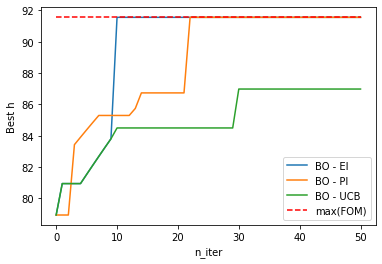

In [10]:
n_iterations = 50

plt.plot(h_best_EI)
plt.plot(h_best_PI)
plt.plot(h_best_UCB)
plt.plot(np.linspace(0, n_iterations, n_iterations), [np.max(y)]*n_iterations, 'r--')

plt.xlabel('n_iter')
plt.ylabel('Best h')
plt.legend(['BO - EI', 'BO - PI', 'BO - UCB', 'max(h)'])

#### Running GPR 20 separate times for n_iter = 50
Stochasticity introduced in initial_X and initial_y indices being randomized each time

In [11]:
n_run = 20
h_best_EI, h_best_PI, h_best_UCB = [], [], []

for _ in range(n_run):
    indices = np.random.choice(len(X_norm), size = 10, replace = False)
    initial_X, initial_y = X_norm[indices], y[indices]

    for acq in ['EI', 'PI', 'UCB']:
        if acq == 'EI':
            h_best, _ = get_h_best_acquisition(initial_X, initial_y, X_norm, y, n_iterations=50, acquisition=acq)
            h_best_EI.append(h_best)
        
        elif acq == 'PI':
            h_best, _ = get_h_best_acquisition(initial_X, initial_y, X_norm, y, n_iterations=50, acquisition=acq)
            h_best_PI.append(h_best)
        
        elif acq == 'UCB':
            h_best, _ = get_h_best_acquisition(initial_X, initial_y, X_norm, y, n_iterations=50, acquisition=acq)
            h_best_UCB.append(h_best)

h_best_EI = np.array(h_best_EI)
h_best_PI = np.array(h_best_PI)
h_best_UCB = np.array(h_best_UCB)

Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num.

In [12]:
#this is for EI
std_EI = np.std(h_best_EI, axis = 0)
mean_EI = np.mean(h_best_EI, axis = 0)

#this is for PI
std_PI = np.std(h_best_PI, axis = 0)
mean_PI = np.mean(h_best_PI, axis = 0)

#this is for UCB
std_UCB = np.std(h_best_UCB, axis = 0)
mean_UCB = np.mean(h_best_UCB, axis = 0)

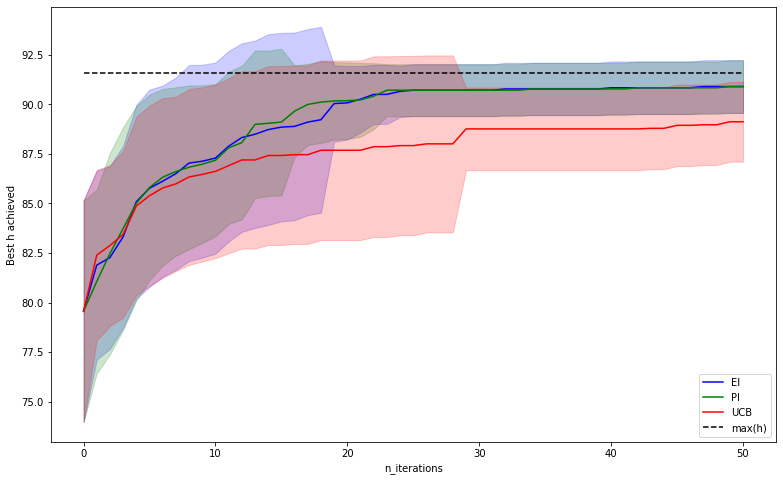

In [13]:
plt.figure(figsize = (13, 8))
plt.plot(mean_EI, label = 'EI', color = 'blue')
plt.fill_between(np.linspace(0, 50, 51), mean_EI - std_EI, mean_EI + std_EI, color='blue', alpha=0.2)

plt.plot(mean_PI, label = 'PI', color = 'green')
plt.fill_between(np.linspace(0, 50, 51), mean_PI - std_PI, mean_PI + std_PI, color='green', alpha=0.2)

plt.plot(mean_UCB, label = 'UCB', color = 'red')
plt.fill_between(np.linspace(0, 50, 51), mean_UCB - std_UCB, mean_UCB + std_UCB, color='red', alpha=0.2)

plt.plot(np.linspace(0, 50, 51), [np.max(y)]*51, 'k--', label = 'max(h)')

plt.xlabel('n_iterations')
plt.ylabel('Best h achieved')

plt.legend(loc = 'lower right')
plt.show()

### Compile the results

In [14]:
#create h -> rank mapping

sorted_unique_h = sorted(set(y), reverse=True)
value_to_rank = {value: rank+1 for rank, value in enumerate(sorted_unique_h)}
h_to_rank = {element: value_to_rank[element] for element in y} #{h : rank}

In [15]:
#random model
#We want to compare to random model
h_best_rand_matrix = []
rank_rand_matrix = []

for _ in range(n_run):
    
    h_best_rand = random_sampling(X_norm, y, n_iterations = 50)
    
    temporary_rank_array = []
    for i in h_best_rand:
        temporary_rank_array.append(np.log(h_to_rank[i]))

    h_best_rand_matrix.append(h_best_rand)
    rank_rand_matrix.append(temporary_rank_array)

h_best_rand_matrix = np.array(h_best_rand_matrix)
rank_rand_matrix = np.array(rank_rand_matrix)

#this is for random sampling (best h)
std_dev_rand = np.std(h_best_rand_matrix, axis = 0)
mean_rand = np.mean(h_best_rand_matrix, axis = 0)

#this is for random sampling (best rank)
std_rank_rand = np.std(rank_rand_matrix, axis = 0)
mean_rank_rand = np.mean(rank_rand_matrix, axis = 0)

Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1


In [17]:
#now, we plot BO with no tuning whatsoever
n_run = 20
h_best_matrix = []
h_pred_matrix = []
rank_best_matrix = []

for _ in range(n_run):
    indices = np.random.choice(len(X_norm), size = 10, replace = False)
    initial_X, initial_y = X_norm[indices], y[indices]

    h_best, h_pred = get_h_best(initial_X, initial_y, X_norm, y, n_iterations=50)
    rank_best = get_rank_best(initial_X, initial_y, X_norm, y, h_to_rank, n_iterations = 50)
    h_best_matrix.append(h_best)
    h_pred_matrix.append(h_pred)
    rank_best_matrix.append(np.log10(rank_best))

h_best_matrix = np.array(h_best_matrix)
h_pred_matrix = np.array(h_pred_matrix)
rank_best_matrix = np.array(rank_best_matrix)

#this is for BO (non-rank)
std_dev_vector = np.std(h_best_matrix, axis = 0)
mean_vector = np.mean(h_best_matrix, axis = 0)

#this is for BO (rank)
std_dev_rank = np.std(rank_best_matrix, axis = 0)
mean_rank = np.mean(rank_best_matrix, axis = 0)

Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1


In [41]:
#now we plot BO with the tuning + acquisition function selected - EI, PI, UCB are computed 
n_run = 20
h_best_EI, h_best_PI, h_best_UCB = [], [], []

for _ in range(n_run):
    indices = np.random.choice(len(X_norm), size = 10, replace = False)
    initial_X, initial_y = X_norm[indices], y[indices]

    for acq in ['EI', 'PI', 'UCB']:
        if acq == 'EI':
            h_best, _ = get_h_best_acquisition(initial_X, initial_y, X_norm, y, n_iterations=50, acquisition=acq, kernel = Matern(length_scale=1.0))
            h_best_EI.append(h_best)
        
        elif acq == 'PI':
            h_best, _ = get_h_best_acquisition(initial_X, initial_y, X_norm, y, n_iterations=50, acquisition=acq, kernel = Matern(length_scale=1.0))
            h_best_PI.append(h_best)
        
        elif acq == 'UCB':
            h_best, _ = get_h_best_acquisition(initial_X, initial_y, X_norm, y, n_iterations=50, acquisition=acq, kernel = Matern(length_scale=1.0))
            h_best_UCB.append(h_best)

h_best_EI = np.array(h_best_EI)
h_best_PI = np.array(h_best_PI)
h_best_UCB = np.array(h_best_UCB)

#this is for EI
std_EI = np.std(h_best_EI, axis = 0)
mean_EI = np.mean(h_best_EI, axis = 0)

#this is for PI
std_PI = np.std(h_best_PI, axis = 0)
mean_PI = np.mean(h_best_PI, axis = 0)

#this is for UCB
std_UCB = np.std(h_best_UCB, axis = 0)
mean_UCB = np.mean(h_best_UCB, axis = 0)

Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num.

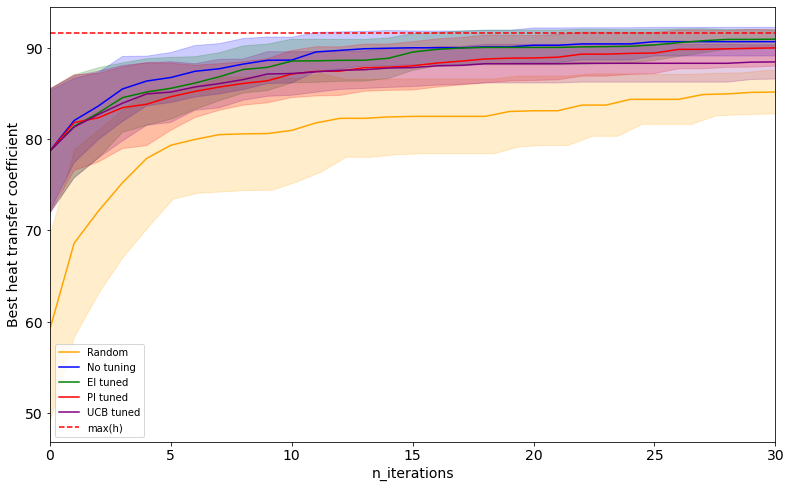

In [54]:
plt.figure(figsize = (13, 8))

plt.plot(mean_rand, label = 'Random', color = 'orange')
plt.fill_between(np.linspace(0, 50, 50), mean_rand - std_dev_rand, mean_rand + std_dev_rand, color = 'orange', alpha = 0.2)

plt.plot(mean_vector, label = 'No tuning', color = 'blue')
plt.fill_between(np.linspace(0, 50, 51), mean_vector - std_dev_vector, mean_vector + std_dev_vector, color='blue', alpha=0.2)

plt.plot(mean_EI, label = 'EI tuned', color = 'green')
plt.fill_between(np.linspace(0, 50, 51), mean_EI - std_EI, mean_EI + std_EI, color = 'green', alpha = 0.2)

plt.plot(mean_PI, label = 'PI tuned', color = 'red')
plt.fill_between(np.linspace(0, 50, 51), mean_PI - std_PI, mean_PI + std_PI, color = 'red', alpha = 0.2)

plt.plot(mean_UCB, label = 'UCB tuned', color = 'purple')
plt.fill_between(np.linspace(0, 50, 51), mean_UCB - std_UCB, mean_UCB + std_UCB, color = 'purple', alpha = 0.2)

plt.plot(np.linspace(0, 50, 51), [np.max(y)]*51, 'r--', label = 'max(h)')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('n_iterations', fontsize = 14)
plt.ylabel('Best heat transfer coefficient', fontsize = 14)

plt.xlim([0, 30])
plt.savefig('figures/compiled_results.svg')
plt.legend()

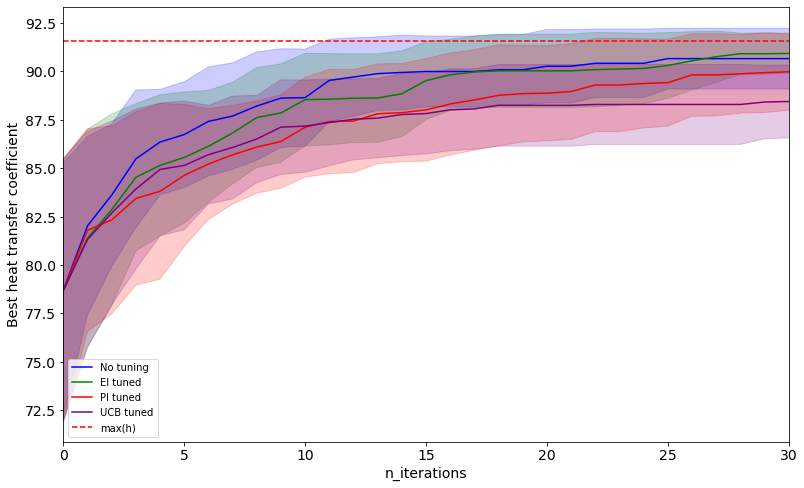

In [53]:
plt.figure(figsize = (13, 8))

plt.plot(mean_vector, label = 'No tuning', color = 'blue')
plt.fill_between(np.linspace(0, 50, 51), mean_vector - std_dev_vector, mean_vector + std_dev_vector, color='blue', alpha=0.2)

plt.plot(mean_EI, label = 'EI tuned', color = 'green')
plt.fill_between(np.linspace(0, 50, 51), mean_EI - std_EI, mean_EI + std_EI, color = 'green', alpha = 0.2)

plt.plot(mean_PI, label = 'PI tuned', color = 'red')
plt.fill_between(np.linspace(0, 50, 51), mean_PI - std_PI, mean_PI + std_PI, color = 'red', alpha = 0.2)

plt.plot(mean_UCB, label = 'UCB tuned', color = 'purple')
plt.fill_between(np.linspace(0, 50, 51), mean_UCB - std_UCB, mean_UCB + std_UCB, color = 'purple', alpha = 0.2)

plt.plot(np.linspace(0, 50, 51), [np.max(y)]*51, 'r--', label = 'max(h)')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('n_iterations', fontsize = 14)
plt.ylabel('Best heat transfer coefficient', fontsize = 14)

plt.xlim([0, 30])
plt.savefig('figures/compiled_no_rand.svg')
plt.legend()